## Imports

In [2]:
import os
import pandas as pd
import plotly.express as px
import random
# import matplotlib.pyplot as plt
from trackml.dataset import load_event

## Load in Event

In [3]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('./input/train_100_events', event_prefix));

Goal: Find out how many particles have hits in volume_id 8,13,17

In [4]:
particle_ids = truth.particle_id.unique()
num_particles_tot = len(particle_ids)

## Data Summary

In [17]:
hits.head()

hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1
4       5 -62.673599 -9.371200 -1502.5          7         2          1

In [18]:
cells.head()

hit_id  ch0  ch1     value
0       1  209  617  0.013832
1       1  210  617  0.079887
2       1  209  618  0.211723
3       2   68  446  0.334087
4       3   58  954  0.034005

In [19]:
particles.head()

particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.010060  1     11  
2   0.683881 -1      0  
3   0.991616  1     12  
4 -39.824902  1      3

In [20]:
truth.head()

hit_id         particle_id         tx        ty      tz            tpx  \
0       1                   0 -64.411598 -7.164120 -1502.5  250710.000000   
1       2   22525763437723648 -55.338501  0.630805 -1502.5      -0.570605   
2       3                   0 -83.828003 -1.145580 -1502.5  626295.000000   
3       4  297237712845406208 -96.122902 -8.230360 -1502.5      -0.225235   
4       5  418835796137607168 -62.659401 -9.375040 -1502.5      -0.281806   

             tpy           tpz    weight  
0 -149908.000000 -956385.00000  0.000000  
1       0.028390     -15.49220  0.000010  
2 -169767.000000 -760877.00000  0.000000  
3      -0.050968      -3.70232  0.000008  
4      -0.023487      -6.57318  0.000009

## Extract hits \& Filter

In [48]:
vol_ids = [8,13,17]
hits_in_barrel = hits[hits['volume_id'].isin(vol_ids)] # problem, definitely includes particles that leave barrel and return
hits_in_barrel.head()

hit_id          x          y           z  volume_id  layer_id  \
16873   16874 -32.554401  -3.648710 -469.864990          8         2   
16874   16875 -33.153702  -1.934740 -423.516998          8         2   
16875   16876 -26.362400 -18.423700 -461.375000          8         2   
16876   16877 -12.034100 -29.649799 -464.428009          8         2   
16877   16878 -15.127200 -28.159300 -439.713989          8         2   

       module_id  
16873          1  
16874          1  
16875          2  
16876          3  
16877          3

Need to filter again by going into `truth` and filtering trajectories that leave barrel and return

In [63]:
barrel_hit_ids = hits_in_barrel.hit_id.unique()
unique_particle_ids_in_barrel = truth[(truth['hit_id'].isin(barrel_hit_ids))].particle_id.unique()

Now we need to make sure that all of these particles actually have hits in the right volume_id, so we go through all of them and validate it manually, I am sure there is a better way to do this, but it only takes a couple seconds to run

In [69]:
valid_particle_ids = []
for particle in unique_particle_ids_in_barrel:
    trajectory = truth[truth['particle_id'] == particle].hit_id.unique()
    # if trajectory contains volume_ids other than [8,13,17], we reject it
    volume_ids_from_hits = hits[hits['hit_id'].isin(trajectory)].volume_id.unique()
    # invalid if there is a volume_id other than 8,7,13
    if all(v in vol_ids for v in volume_ids_from_hits): # if true, add to valid
        valid_particle_ids.append(particle)

In [70]:
num_particles_barrel = len(valid_particle_ids)
percent = 100 * num_particles_barrel / num_particles_tot
print('Number of particles in total: {}\nNumber of Particles with hits in barrel: {}\nPercent of total: {:.3f}%'.format(
    num_particles_tot,num_particles_barrel,percent))

Number of particles in total: 10566
Number of Particles with hits in barrel: 3626
Percent of total: 34.318%


## Plot it

/tmp/ipykernel_95557/923456000.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



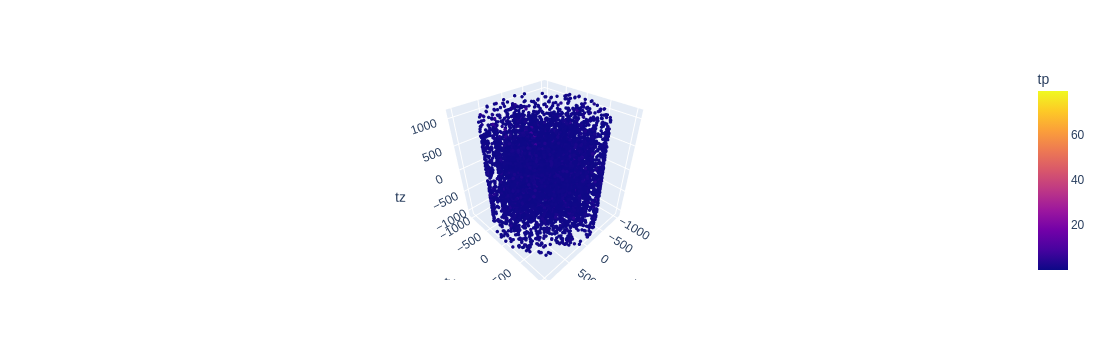

In [81]:
true_hits = truth[truth['particle_id'].isin(valid_particle_ids)]
true_hits['tp'] = (true_hits['tpx']**2+true_hits['tpy']**2+true_hits['tpz']**2)**0.5
fig = px.scatter_3d(true_hits, x='tx', y='ty', z='tz', color='tp')
fig.update_traces(marker=dict(size=2))
fig.show()